# LIGO data analysis
## Data Loading

In [1]:
import h5py
import pandas as pd

f = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')
keys = list(f.keys())

max_n = int(1e5)

# Extract and slice data from each dataset
data = {}
for k in keys:
    data[k] = f[k][:max_n]
f.close()

df = pd.DataFrame(data)

df

,chi1x,chi1y,chi1z,chi2x,chi2y,chi2z,dec,det,iota,mtot,psi,q,ra,snr,z
0,-0.307201,0.276165,-0.430760,-0.161114,-0.092334,-0.414647,-0.329671,0,1.809310,906.803562,1.286031,0.624780,-3.116784,0.822509,2.139659
1,-0.734712,-0.498493,-0.298162,0.057532,-0.844992,0.014708,0.526740,0,0.820820,59.102112,0.934308,0.986650,1.360291,1.093237,2.438707
2,-0.057831,-0.703796,-0.354512,-0.215538,0.016323,0.130543,0.315799,0,2.008206,44.602750,1.535520,0.286199,0.079973,1.305398,1.869461
3,0.015260,-0.202467,-0.492768,-0.237033,-0.365363,-0.876192,0.432105,0,2.018398,534.378032,3.064086,0.538882,-1.780558,9.112974,0.428061
4,-0.016731,0.007848,0.005007,0.147519,0.231879,0.086716,-0.458711,1,2.037363,573.821705,0.752211,0.846310,2.789289,17.525534,0.772609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.710484,0.203788,-0.030539,-0.194861,0.014570,-0.054834,-0.239913,0,1.905192,326.220322,1.473113,0.802986,1.273264,1.669939,1.901201
99996,0.804222,0.086352,0.550408,0.181968,0.824057,0.412858,0.195437,0,1.920145,403.949547,0.184597,0.386258,-1.279446,6.605718,1.491419
99997,0.652722,-0.022264,0.132145,0.272847,0.381442,0.773596,-0.584279,1,2.637491,884.399749,1.601521,0.722733,0.444194,14.355243,0.735589
99998,-0.134977,0.016409,-0.207572,-0.100090,0.117877,0.054799,0.754165,1,1.147342,949.832616,0.060168,0.459489,-0.415330,12.521137,0.394833


## Training and Test sets creation

In [2]:
from sklearn.model_selection import train_test_split

y_clas = df['det']
y_reg = df['snr']
X = df.drop(columns=['det', 'snr'])

X_train, X_test, y_clas_train, y_clas_test, y_reg_train, y_reg_test = train_test_split(X, y_clas, y_reg, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_clas_train.shape, y_clas_test.shape)

(80000, 13) (20000, 13) (80000,) (20000,)


## Classification with different algorithms
### Support Vector Machine (SVM)    
To talk about this algorithm we have to start talking about the **Logistic Regression**. This is a classification algorithm that uses the logistic function to model a binary dependent variable. The logistic function is defined as:
$$
p(C=1|x) = \frac{\exp\left(\sum_j\theta_jx^j \right)}{1 + \exp\left(\sum_j\theta_jx^j \right)}\hspace{1cm}\log\bigg(\frac{p(C=1|\vec{x})}{p(C=0|\vec{x})}\bigg) = \beta + \vec{w}^T \vec{x}
$$
The logarithm of the posterior is a linear function of the input variables, similar to LDA. The only difference is how the regression coefficients are estimated. In LDA they are chosen to minimize density estimation error, whereas in Logistic Regression they are chosen to minimize classifcation error.

The idea behind SVM is to find a hyperplane that best divides a dataset into two classes. To do this the distance between the hyperplane and the nearest data point from either class is maximized. 
$$
\text{maximize } M\, \text{ subject to }\, \frac{1}{||\vec{w}||_2}C_i(\beta + \vec{w}^T \vec{x}) \geq M
$$
This is equivalent to minimizing:
$$
\text{minimize } \frac{1}{2}||\vec{w}||_2 \, \text{ subject to }\, C_i(\beta + \vec{w}^T \vec{x}) \geq 1
$$  


In [3]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svc = SVC(kernel='rbf', C=200, probability=True) #'rbf' is a non-linear kernel
svc.fit(X_train, y_clas_train)
y_pred_svc = svc.predict(X_test)
accuracy_svc = accuracy_score(y_clas_test, y_pred_svc)
print(f"Accuracy SVC: {accuracy_svc}")

Accuracy SVC: 0.94655


$C$ is a regularization parameter. The strength of the regularization is inversely proportional to $C$. The penalty is a squared L2 penalty.

### Decision Tree
A Decision Tree is similar to the process of classification that you might do by hand: 

- Define some criteria to separate the sample into 2 groups (not necessarily equal).
- Then take those sub-groups and do it again.  
- Keep going until you reach a stopping point such as not having a minimum number of objects to split again.  

In short, we have done a hierarchical application of decision boundaries.

The tree structure is as follows:
- Top node contains the entire data set.
- At each branch the data are subdivided into two child nodes. 
- Split is based on a predefined decision boundary (usually axis aligned).
- Splitting repeats, recursively, until we reach a predefined stopping criteria.


Now can ask how to choose the splitting criteria at each node, there are different possibilities, in the following lines we'll see two of them:
- **Gini coefficient**: it estimates the probability of incorrect classification of a random element in the dataset. It can be computed as:
    $$
    G = \sum_{k} p(C_k|\vec{x}) (1 -  p(C_k|\vec{x}))
    $$
    where $p(C_k|\vec{x})$ is the probability of a particular class $C_k$ given the training data $\vec{x}$. 
    This criterion is the default one in `sklearn.tree.DecisionTreeClassifier`.

- **Information Gain (IG)**: it is based on the concept of **entropy**, which measures the amount of uncertainty or randomness in a dataset. The entropy can be computed as:
    $$
    E = - \sum_{k} p(C_k|\vec{x})\log(p(C_k|\vec{x}))
    $$  
    We can define the IG as the reduction in entropy after the dataset is split on an attribute. It can be computed as:
    $$
    IG = E_{\text{parent}} - \sum_{j=0}^1 \frac{N_j}{N_{\text{parent}}} E_j
    $$
    where $E_j$ is the entropy of the child node $j$ and $N_j$ is the number of samples in child node $j$. The IG measures how much information is gained by splitting the dataset on a particular attribute. The attribute with the highest IG is chosen as the splitting criterion at each node.
    

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV 
import numpy as np

dtc = DecisionTreeClassifier()
max_depth = np.arange(1, 21)
best_dtc = GridSearchCV(dtc, {'max_depth': max_depth}, cv=5)
best_dtc.fit(X_train, y_clas_train)
y_pred_dtc = best_dtc.predict(X_test)
accuracy_dtc = accuracy_score(y_clas_test, y_pred_dtc)
print(f"Accuracy DTC: {accuracy_dtc}")

dtc_entropy = DecisionTreeClassifier(criterion='entropy')
best_dtc_entropy = GridSearchCV(dtc_entropy, {'max_depth': max_depth}, cv=5)
best_dtc_entropy.fit(X_train, y_clas_train)
y_pred_dtc_entropy = best_dtc_entropy.predict(X_test)
accuracy_dtc_entropy = accuracy_score(y_clas_test, y_pred_dtc_entropy)
print(f"Accuracy DTC (entropy): {accuracy_dtc_entropy}")

Accuracy DTC: 0.9573
Accuracy DTC (entropy): 0.95795


### Random Forest
The Random Forest algorithm is an **ensemble learning** method that combines multiple decision trees. 
Another method of ensemble learning is **bagging** (Bootstrap Aggregating), which involves training multiple models on different subsets of the data (generated with bootstrap) and then combining their predictions. 
$$
\hat{C} = \frac{1}{B} \sum_{j=1}^{B} f_j(\vec{x}_j)
$$
where $f_j$ is the prediction from the $j^{th}$ dataset and $B$ is the total number of bootsrapped datasets.

Random Forest is a specific type of bagging that uses randomly selected subsets of features to train each decision tree in the ensemble.

- In Random Forests, the ***splitting features on which to generate the tree are selected at random*** from the full set of features in the data.
- The number of features selected per split level is typically the square root of the total number of features, $\sqrt{D}$. 
- The fundamental difference is that in Random forests, only a subset of features are selected at random out of the total and the best split feature from the subset is used to split each node in a tree, unlike in bagging where all features are considered for splitting a node. 
- The final classification from the random forest is based on the averaging of the classifications of each of the individual decision trees.

In [5]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
n_estimators = [10, 50, 100, 200]
best_rfc = GridSearchCV(rfc, {'n_estimators': n_estimators}, cv=5)
best_rfc.fit(X_train, y_clas_train)
y_pred_rfc = best_rfc.predict(X_test)
accuracy_rfc = accuracy_score(y_clas_test, y_pred_rfc)
print(f"Accuracy RFC: {accuracy_rfc}")

Accuracy RFC: 0.96585


## Results comparison

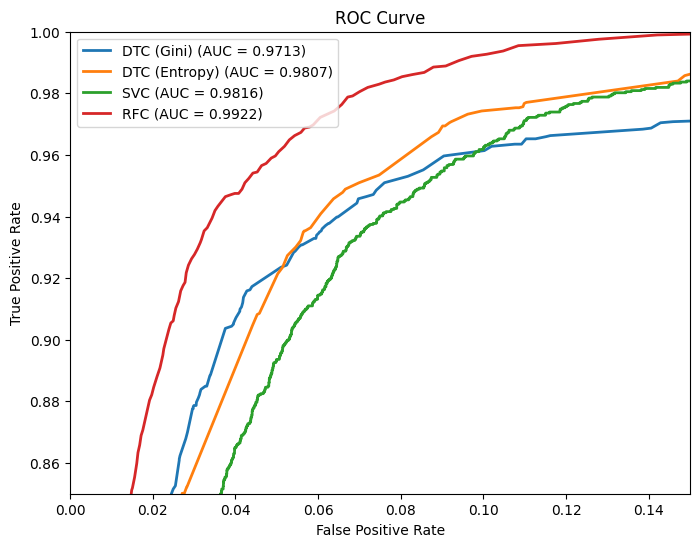

In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_pred_proba_dtc = best_dtc.predict_proba(X_test)[:, 1]
y_pred_proba_dtc_entropy = best_dtc_entropy.predict_proba(X_test)[:, 1]
y_pred_proba_svc = svc.predict_proba(X_test)[:, 1]
y_pred_proba_rfc = best_rfc.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC for the Gini model
fpr_dtc, tpr_dtc, _ = roc_curve(y_clas_test, y_pred_proba_dtc)
roc_auc_dtc = auc(fpr_dtc, tpr_dtc)

# Calculate ROC curve and AUC for the Entropy model
fpr_dtc_entropy, tpr_dtc_entropy, _ = roc_curve(y_clas_test, y_pred_proba_dtc_entropy)
roc_auc_dtc_entropy = auc(fpr_dtc_entropy, tpr_dtc_entropy)

# Calculate ROC curve and AUC for the SVC model
fpr_svc, tpr_svc, _ = roc_curve(y_clas_test, y_pred_proba_svc)
roc_auc_svc = auc(fpr_svc, tpr_svc)

# Calculate ROC curve and AUC for the RFC model
fpr_rfc, tpr_rfc, _ = roc_curve(y_clas_test, y_pred_proba_rfc)
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_dtc, tpr_dtc, lw=2, label=f'DTC (Gini) (AUC = {roc_auc_dtc:.4f})')
plt.plot(fpr_dtc_entropy, tpr_dtc_entropy, lw=2, label=f'DTC (Entropy) (AUC = {roc_auc_dtc_entropy:.4f})')
plt.plot(fpr_svc, tpr_svc, lw=2, label=f'SVC (AUC = {roc_auc_svc:.4f})')
plt.plot(fpr_rfc, tpr_rfc, lw=2, label=f'RFC (AUC = {roc_auc_rfc:.4f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0, 0.15])
plt.ylim([0.85, 1])
plt.title('ROC Curve')
plt.legend(loc="upper left")
plt.show()

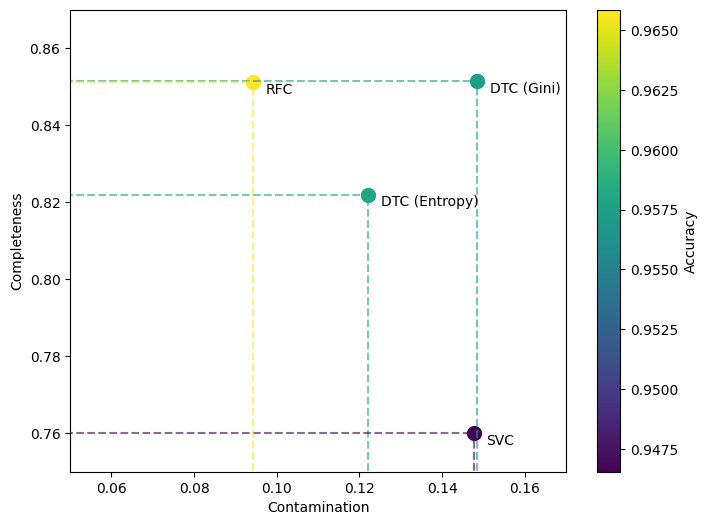

In [ ]:
from astroML.utils import completeness_contamination

completeness_dtc, contamination_dtc = completeness_contamination(y_pred_dtc, y_clas_test)
completeness_dtc_entropy, contamination_dtc_entropy = completeness_contamination(y_pred_dtc_entropy, y_clas_test)
completeness_svc, contamination_svc = completeness_contamination(y_pred_svc, y_clas_test)
completeness_rfc, contamination_rfc = completeness_contamination(y_pred_rfc, y_clas_test)

accuracies = [accuracy_dtc, accuracy_dtc_entropy, accuracy_svc, accuracy_rfc]

norm = plt.Normalize(min(accuracies), max(accuracies))
cmap = plt.cm.viridis 

plt.figure(figsize=(8, 6))

sc = None # For saving the mappable scatter

for x, y, label, acc in zip(
    [contamination_dtc, contamination_dtc_entropy, contamination_svc, contamination_rfc],
    [completeness_dtc, completeness_dtc_entropy, completeness_svc, completeness_rfc],
    ['DTC (Gini)', 'DTC (Entropy)', 'SVC', 'RFC'],
    accuracies
):
    color = cmap(norm(acc))
    sc = plt.scatter(x, y, marker='o', c=[acc], cmap=cmap, norm=norm, s=100)  # Usa 'c' per mappable
    plt.vlines(x, 0, y, color=color, linestyles='dashed', alpha=0.6)
    plt.hlines(y, 0, x, color=color, linestyles='dashed', alpha=0.6)
    plt.text(x + 0.003, y - 0.003, label, fontsize=10, color='black')

cbar = plt.colorbar(sc)
cbar.set_label('Accuracy')

plt.xlim([0.05, 0.17])
plt.ylim([0.75, 0.87])
plt.xlabel('Contamination')
plt.ylabel('Completeness')
plt.show()

As we can expected the Random Forest Classifier is the one that performs better. 